# ¡The Dataset(s)!

For this challenge, I used two datasets: the **VCTK** dataset (https://datashare.ed.ac.uk/handle/10283/3443) and the **VoxCeleb1** dataset (https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html). I do a little data exploration below.

## VCTK
The *CSTR VCTK Corpus: English Multi-speaker Corpus for CSTR Voice Cloning Toolkit* is a dataset from 2019 composed of English sentences spoken by 110 different speakers into the same microphone/room setup. Each speaker said about 400 sentences, totalling ______ hours of speech. 

I selected this dataset because it has sentences labeled by who said them (very useful for supervised speaker segmentation) and a nice, uniform recording setup that should make the data fairly clean. I consider this dataset to be the easy one, as the methods I applied always seemed to "solve" the dataset better than on **VoxCeleb1**. Also, the dataset sounds fairly uniform on an inter and intra-sentence level, although I'd like to think I normalize enough that that doesn't matter.

Below I do a bit of looking at the balance of the dataset and investigate a couple data points to see how to best featurize and learn from them. 

In [ ]:
# pie charts of dataset split by speaker, by length, etc

# show proportion of data that is silence and some preprocessing

# show spectrograms and log spectrograms

# talk about 0.5s wav split

## VoxCeleb1
The *VoxCeleb1* is a 2017 audio-visual (although I only take the audio and labels) dataset of English sentences said by celebrities in youtube interviews. There are 1211 different speakers in this dataset (at least in the train split, which was all my computer could fit lol), totaling 148642 utterances, each of duration at least 3 seconds (see below). It was a total pain to get this dataset, since I had to contact the authors for permission to download the 39Gb dataset through a comically slow server they set up. 

I selected this dataset because it seemed to me to be more representative of the "wild", with different microphone setups and conditions that are altogether less curated. Also, the larger number of speakers and datapoints gives models trained on this dataset a different flavor that I think is valuable to include. Everything sounds pretty good in this dataset, as far as microphone quality and audio balancing (as one would expect from an interview), and the dataset designers did a good job of stripping away silence and anomalous things, leaving a big and solid dataset.

Below I look at how the dataset is constructed and, like for the **VCTK** dataset I pick a few examples to look closely at.

In [ ]:
# pie charts once again

# show some preprocessing (though i dont do any?)

# show spectrograms vs filter banks 

# talk about 0.5s wav split once again

# play some example audio

# ¡The Model(s)!
We decided above that we would featurize each clip using log-mel spectrograms in order to capture both frequency and time features (we expect frequency traits to be characteristic of certain speakers, but perhaps how quickly they modulate frequency and other time-dependent features are also useful). So, the model will take as input a 2D (normalized, log-mel) spectrogram over the *(time, frequency)* dimensions as input; clearly, it will be built with mainly Conv2D layers. (*I actually played around a bit with also having a head for 1D convolutions over the entire waveform that I would concatenate with the spectrogram head before passing to the body, but it was a waste of computation and parameters that only hurt*). I split my model engineering into two branches, which are related but different: 
- **(1)** an energy-based speaker compatibility approach and 
- **(2)** contrastively learned speaker representations. 

I talk about these design decisions, the process, and the results below.

## Energy-Based Model
My mind immediately turned to this perspective on the problem, most likely because while I was thinking about this I was also putting together a presentation on physics-inspired deep learning and energy models for the AI club I run here at Princeton. The actual stuff I was presenting was kinda different, but the perspective of learning an energy landscape was certainly on my mind. 

I actually frame this approach as follows: since the problem centers around detecting when the active speaker changes, a useful subproblem is to be able to distinguish if speakers in two clips are the same speaker or not. The energy model then takes two inputs - the two (not necessarily adjacent) clips - and outputs a prediction for whether the two clips come from the same speaker or not, without the need to explicitly identify any speakers. This is basically a binary classification problem (in fact I use binary cross entropy loss over the output logits to train this) but I began thinking about it with more involved energy-based machinery and loss function wizardry like hinge and triplet and LVQ2 losses. In the end, I decided to first implement this simple probability-of-same-speaker thing and save some fun stuff for the second approach.

The model uses one convolutional head that "encodes" both inputs and concatenates them, which a FCNN body then distills down to a single output neuron. I sample positive and negative pairs with equal probability (*because any probability between 0.3 and 0.7 didn't seem to make a difference*) and go at it! I initially trained one energy model for each dataset, but I soon realized I could train one for both (*it's using the same clip size and same sampling freq after resampling, so why not?; for the contrastive stuff I separate it out though*).

Below I take some examples from both datasets and look at how the combined model does. I also build a confusion matrix in order to see if the error is systematic.

In [ ]:
# cherry pick examples

# MAKE CONFUSION MATRIX

# look up metadata to see if it gets gender things right/wrong, etc.

## Contrastive Model
As I was implementing the energy-based model, I realized I was kind of dancing around explicitly learning speaker representations. The convolutional head in the above model basically plays the role of an encoder, with the hope that the encoding relays speaker information and not much else. At that point, I might as well directly encode speakers, which is what I do here.

I frame the model in the traditional contrastive learning way: I wish to learn an embedding space that places clips from the same speaker together and clips from different speakers far away. One cool point in this setup is that I have the actual speaker labels and more than enough data, and so I don't really need augmentation for positive pair generation or anything. I don't do any hard negative mining because I didn't have the time or computational stuffs to get it done, but I imagine that would be a large area for improvement. So, everything that isn't a positive pair is equally negative. (*Cool side note: I actually pretrained these embedding models by attaching a linear classifier to the output and using cross-entropy loss over the task of speaker classification to get a rough first start - I then fine-tuned the embedding spaces with contrastive learning*). 

I experimented with a Triplet Loss for triplets of *(anchor, pos, neg)* and a supervised contrastive loss that uses the explicit labels to consider all possible pairs - as expected, the supervised contrastive loss does better, and so I stuck with that (*I also briefly tried InfoNCE, Soft Nearest Neighbors, and some of the other usual contrastive suspects, but I think the SupCon does better in the fully-supervised setting as the name suggests*). This time, I trained one model for each dataset, since I think the different scales of speaker variation and dataset regularity would shake things up more in this setting than in the energy-based one. I didn't really put my all into a combined model, though, and if I had more time I would like to take a look at that too.

Below I scrutinize some specific examples from both datasets and visualize the generated embedding spaces.

In [ ]:
from scipy.io import wavfile
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import tqdm

from contrastive import ContrastiveModel, VCTKClassifierDataset

Turned embedding mode on!
TSNE'ing VCTK


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 191.00it/s]


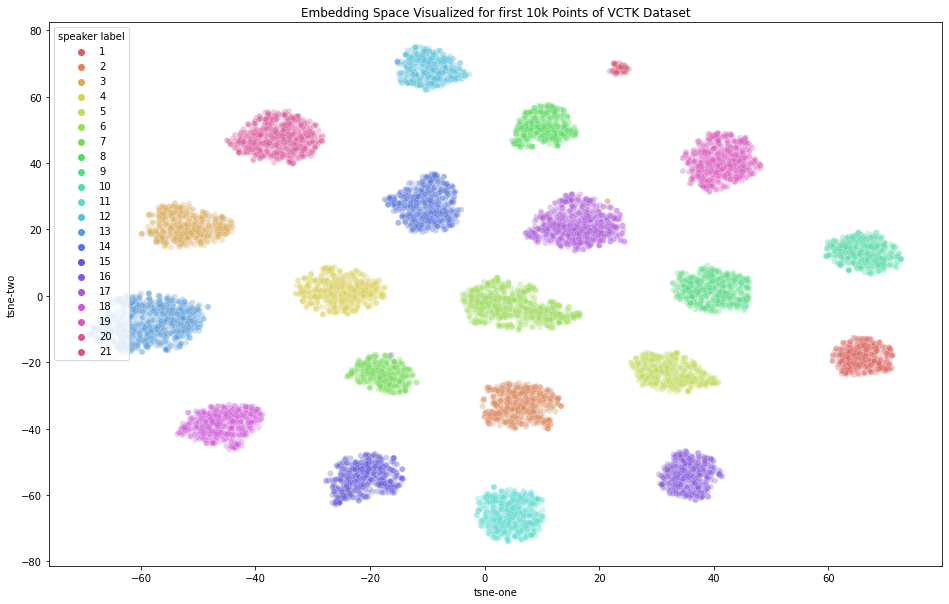

In [43]:
# load dataframe linking .wav files to speakers
vctk_df = VCTKClassifierDataset('all').df.iloc[:10000]

# load models
vctk = ContrastiveModel.load('checkpoints/models/vctk_emb.pth').toggle_emb_mode().eval()

# embed the VCTK dataset!
print('TSNE\'ing VCTK')
with torch.no_grad():
    embs = []
    labels = []
    for path, label in tqdm.tqdm(zip(vctk_df['path'], vctk_df['id']), total=len(vctk_df)):
        sr, data = wavfile.read(f'data/VCTK/{path}')  # read in 1 sec wavfile
        embs.append(vctk.emb(torch.tensor(data).reshape(1, -1)).numpy())  # embed
        labels.append(label)
X = np.concatenate(embs, axis=0)

# compute TSNE using cosine distance in the embedding space
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
X_t = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix)
# X_t = TSNE().fit_transform(X)

vctk_tsne_df = pd.DataFrame()
vctk_tsne_df['tsne-one'] = X_t[:,0]
vctk_tsne_df['tsne-two'] = X_t[:,1]
vctk_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 21),  # 21 different speakers in the first 10k data points
    data=vctk_tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('Embedding Space Visualized for first 10k Points of VCTK Dataset')
plt.show()

Turned embedding mode on!
TSNE'ing VoxCeleb1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.31it/s]


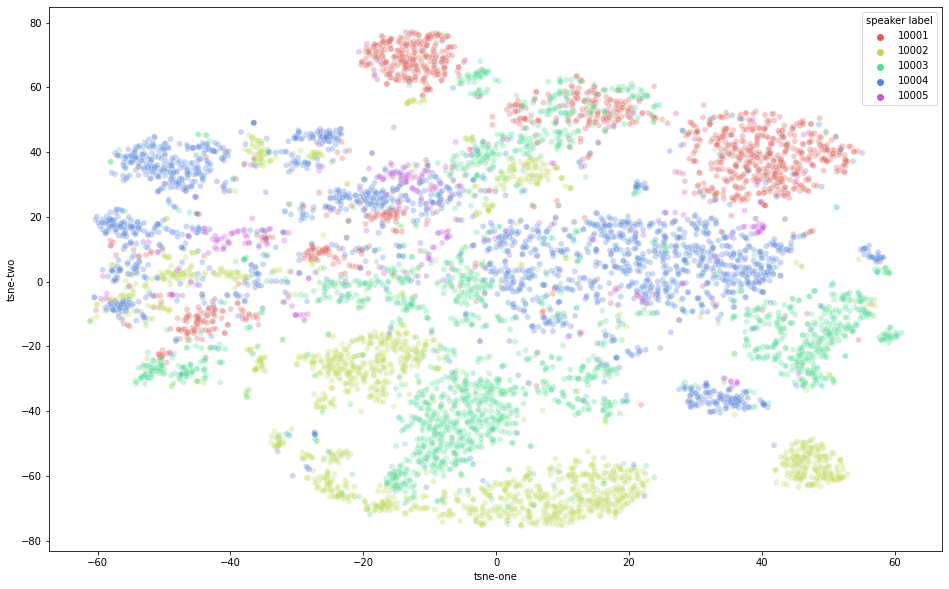

In [44]:
# do the same thing with VoxCeleb1!
vox_df = pd.read_csv('data/vox1/dataset.csv')
vox_df = vox_df.sort_values('speaker')[:500]

vox = ContrastiveModel.load('checkpoints/models/vox_emb.pth').toggle_emb_mode().eval()

print('TSNE\'ing VoxCeleb1')
with torch.no_grad():
    embs = []
    labels = []
    for path, label in tqdm.tqdm(zip(vox_df['path'], vox_df['speaker']), total=len(vox_df)):
        sr, data = wavfile.read(f'data/vox1/{path}')
        for d in np.split(data, np.arange(0, len(data), int(0.5 * sr)))[1:-1]:  # split into 0.5s sections
            embs.append(vox.emb(torch.tensor(d / 2 ** 15).reshape(1, -1)).numpy())
            labels.append(label)
X = np.concatenate(embs, axis=0)

distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
X_t = TSNE(metric="precomputed", square_distances=True).fit_transform(distance_matrix)

vox_tsne_df = pd.DataFrame()
vox_tsne_df['tsne-one'] = X_t[:,0]
vox_tsne_df['tsne-two'] = X_t[:,1]
vox_tsne_df['speaker label'] = labels

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="speaker label",
    palette=sns.color_palette("hls", 5),
    data=vox_tsne_df,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
# "SCRUTININZE EXAMPLES FROM BOTH DATASETS"

# Bringing it Together
With these components (an energy model and two contrastive embedding models), I can try and tackle the general problem outside the domain of my datasets! Clearly, the idea is to compare the current window of speech to whatever came before it (the context) with these speaker comparison tools, and whenever the difference is staggering I declare that the speaker has changed. Because there are 3 models, each with their own qualities that make it useful, I can't definitively say which model is "right" and should be followed. So, I tried to implement as robust of a decoding process as possible, although this felt a lot more like engineering and tinkering to get it right than well-thought-out deep learning design. If I had more time, I would have improved one of the models to the point where it was all that was needed and I could discard the rest, but I actually enjoyed tweaking and balancing everything together to get an end result I could live with. The process goes as follows:
- I keep track of a context of the past ? seconds and a current window of width 0.5 sec. 
- I compare my current window with ? subwindows of the context block via each of the 3 models, and I take the model-wise median of these responses. 
- This yields 3 numbers for each current query window. I compare these numbers to what they looked like in an exponential moving average over previous query windows that I keep track of.
- When there is significant change in any of the 3 models, that model "votes" for a speaker change. If 2/3 models vote, I declare the speaker changed. 

This is very heuristic, but it works! I coded up a little GUI pyaudio script to connect to the microphone, and I also downloaded a 2-person murder mystery podcast so that my framework has some "wild" data to play with. I plot some of the responses in each of the 3 model's channels below.

In [ ]:
# graph of 3 model responses over time (red green blue)